# Experiment: Decision Tree Classifier on Iris dataset with postpruning

## 🧹 Quick Summary: Post-Pruned Decision Tree (Iris Dataset)

**Goal:** First grow a full tree, then **cut back** unnecessary branches to improve generalization.

---

### 🧠 Core Idea:
- Fully grow the tree.
- Use **cost-complexity pruning** (`ccp_alpha > 0`) to trim subtrees that provide little predictive power.

In general...**Pre-pruning** avoids overfitting by stopping early—fast but risks missing patterns; **post-pruning** fixes overfitting by trimming later—slower but usually smarter.

---

### 🧮 Example Configuration:
- `ccp_alpha=0.01` *(depends on validation curve)*
- Train unpruned tree, then prune using validation loss.

---

### 🔧 Implications:

| Aspect          | Expectation | Notes                                  |
|-----------------|-------------|----------------------------------------|
| Accuracy        | High (~95%) | Comparable to pre-pruning when tuned.  |
| Overfitting     | Reduced     | Pruning cuts noise-adapted branches.   |
| Training Time   | Slightly Higher | Pruning is an extra step.         |
| Model Size      | Reduced     | Smaller tree after pruning.            |

It should perform better than pre-pruning but since this is such a small dataset, it might be about the same.

---

### 🔑 Characteristics:
- **Data-driven** complexity control.
- Can outperform pre-pruning when validated well.
- Great for **interpretable and robust** models.

In [7]:
%reload_ext autoreload
%autoreload 2

In [8]:
# decision tree specific imports
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# experiment helper imports
from sklearn.base import clone
from helpers.base_imports import *

## Setup experiment with data and model

https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

In [9]:
exp = Experiment(
    type="c",  # classification
    name="dtc-iris-postpruned",
    dataset="iris-20test-shuffled-v1",
)
exp

Loading 'classification-experiments.csv'
Loading 'dtc-iris-postpruned' experiment
Loading 'dtc-iris-postpruned' estimator/model/pipeline


Experiment(c, dtc-iris-postpruned, iris-20test-shuffled-v1)

We'll start with the regular unpruned DT then check the values of ccp_alpha with a validation curve to see if we can find a good value for pruning.

In [10]:
# add the steps to the pipeline
steps = [
    # NOTE: DTs don't need scaling, but we include it here for consistency when comparing to other classifiers
    ("scaler", StandardScaler()),
    (
        "classifier",
        DecisionTreeClassifier(
            criterion="entropy",  # gini tends to be faster but similar performance
            splitter="best",  # best split or random
            max_depth=None,  # no max depth (so will likely overfit)
            min_samples_split=2,  # require at least 2 samples to split a node
            min_samples_leaf=1,  # require at least 1 sample in each leaf
            min_weight_fraction_leaf=0.0,
            max_features=None,  # consider all features when looking for the best split
            random_state=RANDOM_SEED,
            max_leaf_nodes=None,  # allow unlimited leaf nodes???
            min_impurity_decrease=0.0,  # node will split if decrease in impurity is at least this much
            class_weight=None,  # all classes are weighted/treated equally
            # complexity parameter for minimal cost-complexity pruning, 0 means no pruning
            # greater vals increase the number of nodes pruned
            # therefore greater vals regularize the model more
            ccp_alpha=0.0,
        ),
    ),
]
exp.estimator = Pipeline(
    steps=steps,
    memory=CACHE_DIR,
)

In [11]:
exp.estimator.get_params()

{'memory': '.cache',
 'steps': [('scaler', StandardScaler()),
  ('classifier', DecisionTreeClassifier(criterion='entropy', random_state=0))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': DecisionTreeClassifier(criterion='entropy', random_state=0),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': None,
 'classifier__max_features': None,
 'classifier__max_leaf_nodes': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__monotonic_cst': None,
 'classifier__random_state': 0,
 'classifier__splitter': 'best'}

Get dataset by name (eda already done in another notebook and train/test split saved so we will be working with the same data)

In [12]:
notes, X_train, X_test, y_train, y_test, target_names = get_dataset(exp.dataset)
print(notes)
print(target_names)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Dataset: iris-20test-shuffled-v1
X_train shape: (120, 4)
X_test shape: (30, 4)
y_train shape: (120,)
y_test shape: (30,)
Train: 80.00% of total
Test: 20.00% of total
Notes: None
Created by save_dataset() helper at 2024-07-09 12:28:10

  target_names
0       setosa
1   versicolor
2    virginica


((120, 4), (30, 4), (120, 1), (30, 1))

In [13]:
exp.update_param("n_train_samples", X_train.shape[0])
exp.update_param("n_test_samples", X_test.shape[0])
exp.summary_df

,dataset_name,n_train_samples,n_test_samples,mean_accuracy,split_criterion,train_time,query_time,kfolds,confusion_matrix,classification_report,tree_depth,n_leaves,n_tree_nodes
exp_name,,,,,,,,,,,,,
dtc-iris-postpruned,iris-20test-shuffled-v1,120,30,1.0,entropy,0 days 00:00:00.011213,0 days 00:00:00.000578,Stratified 3-Fold Cross-Validation,[[11 0 0]\n [ 0 13 0]\n [ 0 0 6]],"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",3,4,7.0


We know from previous unpruned experiemnt that 3 works well for StratifiedKFold so we will use that here as well.

## Inspect the cost complexity pruning path

In [14]:
path = exp.estimator.named_steps["classifier"].cost_complexity_pruning_path(
    X_train, y_train
)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

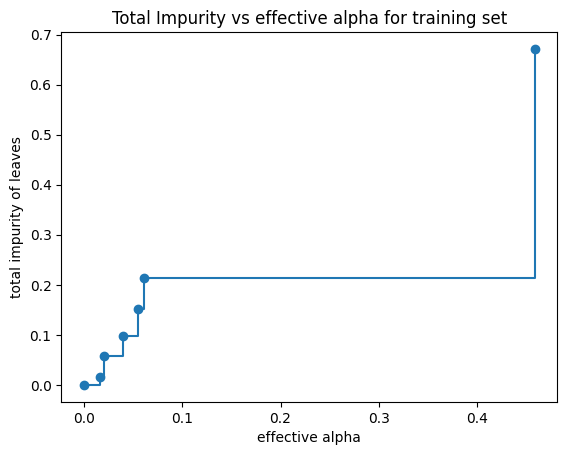

In [9]:
fig, ax = plt.subplots()
# plot all but the last ccp_alpha value since it is the trivial tree with only one node
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
fig.savefig(f"{FIGS_DIR}/{exp.name}-ccp_alphas.png")

Interpretation:
- as we regularize the tree (prune more by increasing ccp_alpha) the tree becomes smaller and smaller and the impurity of the leaves increases

- max effective alpha val is removed since its the trivial tree with just the root node
- the highest effective alpha value is the value that prunes the whole tree

Here we show that the number of nodes and tree depth decreases as alpha increases.

In [15]:
clfs = []
node_counts = []
depths = []
for ccp_alpha in ccp_alphas:
    params = {"classifier__ccp_alpha": ccp_alpha}
    clf = exp.estimator.set_params(**params)
    # print(f"clf params: {clf.get_params()}")
    clf.fit(X_train, y_train)
    node_counts.append(clf.named_steps["classifier"].tree_.node_count)
    depths.append(clf.named_steps["classifier"].get_depth())
    clfs.append(clf)

for i in range(len(clfs)):
    print(
        f"{i}: Number of nodes: {node_counts[i]}, depth: {depths[i]} with ccp_alpha: {ccp_alphas[i]}"
    )

0: Number of nodes: 15, depth: 5 with ccp_alpha: 0.0
1: Number of nodes: 11, depth: 4 with ccp_alpha: 0.015040168643486713
2: Number of nodes: 9, depth: 3 with ccp_alpha: 0.02704260414863776
3: Number of nodes: 7, depth: 3 with ccp_alpha: 0.02947829913342006
4: Number of nodes: 5, depth: 2 with ccp_alpha: 0.126251527242787
5: Number of nodes: 3, depth: 1 with ccp_alpha: 0.45850626956603496
6: Number of nodes: 1, depth: 0 with ccp_alpha: 0.9097361225311661


In [16]:
# remove the last tree (which has only one node)
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
depths = depths[:-1]
node_counts = node_counts[:-1]

for i in range(len(clfs)):
    print(
        f"{i}: Number of nodes: {node_counts[i]}, depth: {depths[i]} with ccp_alpha: {ccp_alphas[i]}"
    )

0: Number of nodes: 15, depth: 5 with ccp_alpha: 0.0
1: Number of nodes: 11, depth: 4 with ccp_alpha: 0.015040168643486713
2: Number of nodes: 9, depth: 3 with ccp_alpha: 0.02704260414863776
3: Number of nodes: 7, depth: 3 with ccp_alpha: 0.02947829913342006
4: Number of nodes: 5, depth: 2 with ccp_alpha: 0.126251527242787
5: Number of nodes: 3, depth: 1 with ccp_alpha: 0.45850626956603496


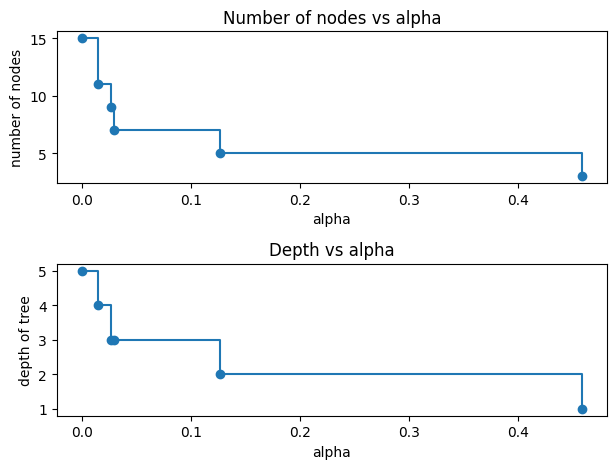

In [17]:
# display number of alpha against numebr of nodes and depth
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depths, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
fig.savefig(f"{FIGS_DIR}/{exp.name}-ccp-alpha-vs-nodes-depth.png")

In [18]:
# TEMP - COOL BUT DOESN"T USE CROSS-VALIDATION???
# train_scores = [clf.score(X_train, y_train) for clf in clfs]
# test_scores = [clf.score(X_test, y_test) for clf in clfs]

# fig, ax = plt.subplots()
# ax.set_xlabel("alpha")
# ax.set_ylabel("accuracy")
# ax.set_title("Accuracy vs alpha for training and testing sets")
# ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
# ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
# ax.legend()
# plt.show()

In [19]:
# TODO - whats RepeatStratifiedKFold?
cv = StratifiedKFold(
    n_splits=3,
    # random_state=RANDOM_SEED, # needed???
)

In [20]:
exp.update_param("kfolds", f"Stratified {cv.get_n_splits()}-Fold Cross-Validation")

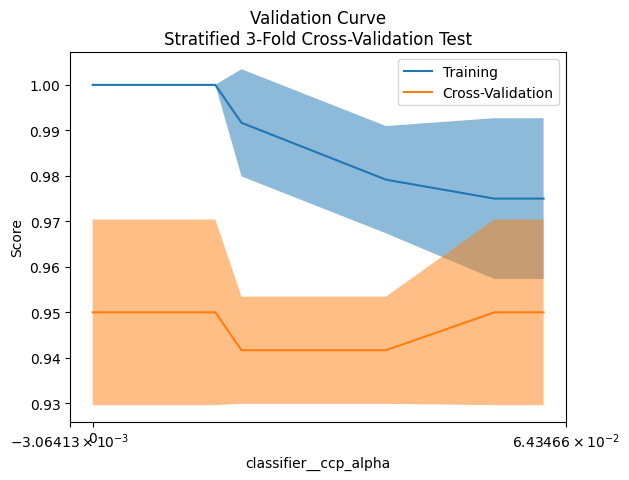

In [16]:
# plot validation curve for ccp_alpha to see how it affects model performance
vcd_min_samples_split = ValidationCurveDisplay.from_estimator(
    estimator=exp.estimator,
    X=X_train,
    y=y_train,
    param_name="classifier__ccp_alpha",
    param_range=ccp_alphas[:-1],  # remove the last value since it is the trivial tree
    cv=cv,
    # shuffle=True,
)
# Update the legend to change "Test" to "Cross-Validation"
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Training", "Cross-Validation"] if "Test" in labels else labels
plt.legend(handles, labels)

plt.title(
    f"Validation Curve\nStratified {cv.get_n_splits()}-Fold Cross-Validation Test"
)
plt.savefig(f"{FIGS_DIR}/{exp.name}_validation-curve-ccp-alpha.png")

So gridsearch should find the value between .015 and .0175 (before CV score starts decreasing)

In [21]:
ccp_alphas

array([0.        , 0.01504017, 0.0270426 , 0.0294783 , 0.12625153,
       0.45850627])

In [22]:
# set hyperparameters and train model (+report)
# perform and report experiments with different hyperparameters
param_grid = {
    "classifier__ccp_alpha": ccp_alphas[:-3],
}

grid_search = GridSearchCV(
    estimator=exp.estimator,
    param_grid=param_grid,
    # scoring="", # accuracy is default but we can use another or many others
    cv=cv,
)
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

({'classifier__ccp_alpha': 0.02704260414863776}, 0.9416666666666665)

In [23]:
grid_search.best_estimator_.get_params()

{'memory': '.cache',
 'steps': [('scaler', StandardScaler()),
  ('classifier',
   DecisionTreeClassifier(ccp_alpha=0.02704260414863776, criterion='entropy',
                          random_state=0))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': DecisionTreeClassifier(ccp_alpha=0.02704260414863776, criterion='entropy',
                        random_state=0),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__ccp_alpha': 0.02704260414863776,
 'classifier__class_weight': None,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': None,
 'classifier__max_features': None,
 'classifier__max_leaf_nodes': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__monotonic_cst': None,
 'classifier__random_state': 0,
 'classifier__splitter': 'best'}

In [24]:
# I prefer the smallest tree that doesn't sacrifice too much accuracy
my_params = {
    "classifier__ccp_alpha": 0.06  # the smallest tree that still gets about .95 on CV accuracy
}
exp.estimator.set_params(**my_params)
exp.estimator.get_params()

{'memory': '.cache',
 'steps': [('scaler', StandardScaler()),
  ('classifier',
   DecisionTreeClassifier(ccp_alpha=0.06, criterion='entropy', random_state=0))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': DecisionTreeClassifier(ccp_alpha=0.06, criterion='entropy', random_state=0),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__ccp_alpha': 0.06,
 'classifier__class_weight': None,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': None,
 'classifier__max_features': None,
 'classifier__max_leaf_nodes': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__monotonic_cst': None,
 'classifier__random_state': 0,
 'classifier__splitter': 'best'}

In [25]:
# fit on training data
start_time = pd.Timestamp.now()
exp.estimator.fit(X=X_train, y=y_train)
train_time = pd.Timestamp.now() - start_time

In [26]:
exp.update_param("train_time", train_time)
exp.update_param(
    "mean_accuracy",
    exp.estimator.score(X_test, y_test),
    # add_column=True
)
exp.summary_df

,dataset_name,n_train_samples,n_test_samples,mean_accuracy,split_criterion,train_time,query_time,kfolds,confusion_matrix,classification_report,tree_depth,n_leaves,n_tree_nodes
exp_name,,,,,,,,,,,,,
dtc-iris-postpruned,iris-20test-shuffled-v1,120,30,0.966667,entropy,0 days 00:00:00.004568,0 days 00:00:00.000578,Stratified 3-Fold Cross-Validation,[[11 0 0]\n [ 0 13 0]\n [ 0 0 6]],"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",3,4,7.0


## Take a look at the trained model

In [27]:
text_representation = export_text(
    exp.estimator.named_steps["classifier"], feature_names=X_train.columns
)
print(text_representation)
with open(f"{RES_DIR}/{exp.name}-dtree.txt", "w") as f:
    f.write(text_representation)

|--- petal width (cm) <= -0.54
|   |--- class: 0
|--- petal width (cm) >  -0.54
|   |--- petal width (cm) <= 0.56
|   |   |--- petal length (cm) <= 0.65
|   |   |   |--- class: 1
|   |   |--- petal length (cm) >  0.65
|   |   |   |--- class: 2
|   |--- petal width (cm) >  0.56
|   |   |--- class: 2



In [28]:
# convert target names series to list
target_names_list = target_names["target_names"].tolist()
target_names_list

['setosa', 'versicolor', 'virginica']

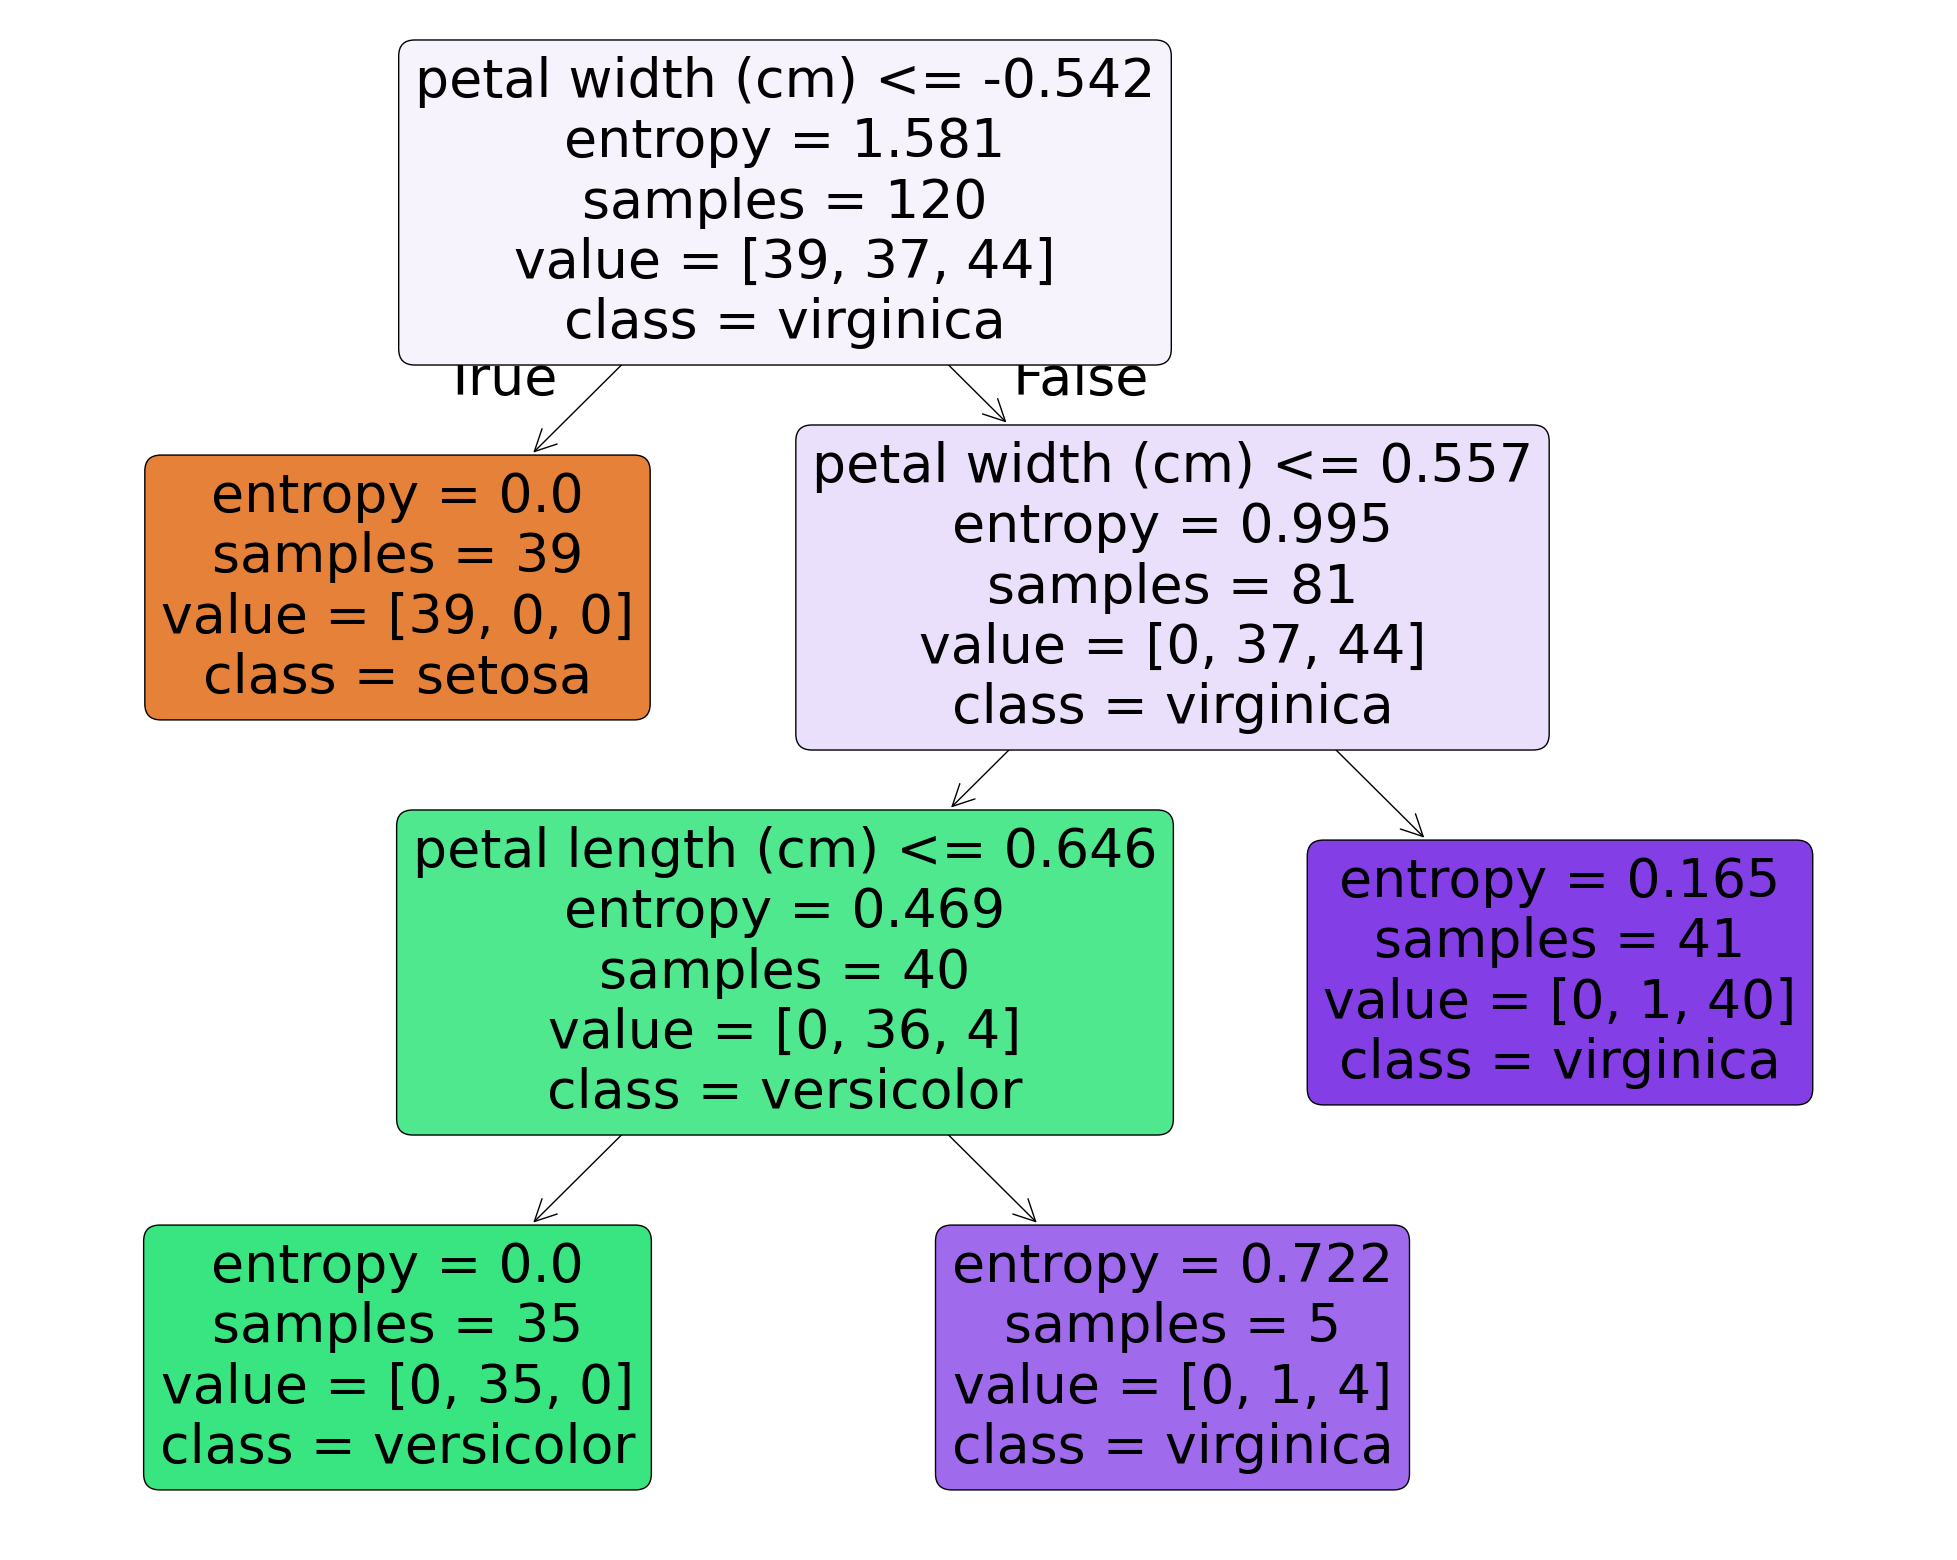

In [29]:
fig = plt.figure(figsize=(25, 20))
plot_tree(
    decision_tree=exp.estimator.named_steps["classifier"],
    feature_names=X_train.columns,
    class_names=target_names_list,
    filled=True,
    rounded=True,
)
plt.savefig(f"{FIGS_DIR}/{exp.name}_tree.png")

In [30]:
# get precision, recall, f1, accuracy
start_time = pd.Timestamp.now()
y_pred = exp.estimator.predict(X_test)
query_time = pd.Timestamp.now() - start_time

In [31]:
exp.update_param("query_time", query_time)

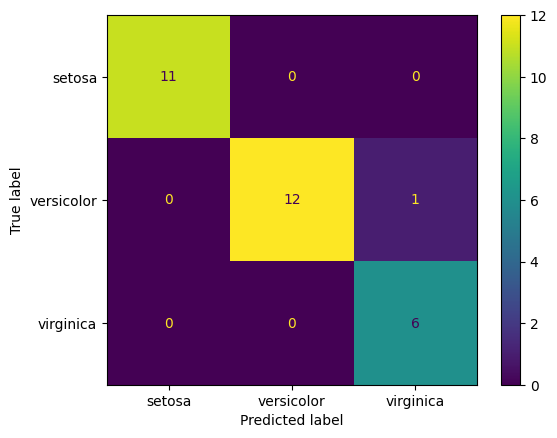

In [ ]:
target_names_list = target_names["target_names"].tolist()
cm = confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    # normalize="true"
)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names_list)
cmd.plot()
plt.title("Confusion Matrix")
plt.savefig(f"{FIGS_DIR}/{exp.name}_confusion-matrix.png")

In [33]:
exp.update_param("confusion_matrix", np.array2string(cm), overwrite_existing=True)

In [34]:
cr = classification_report(y_true=y_test, y_pred=y_pred, output_dict=True)
exp.update_param("classification_report", str(cr), overwrite_existing=True)
cr

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 11.0},
 '1': {'precision': 1.0,
  'recall': 0.9230769230769231,
  'f1-score': 0.96,
  'support': 13.0},
 '2': {'precision': 0.8571428571428571,
  'recall': 1.0,
  'f1-score': 0.9230769230769231,
  'support': 6.0},
 'accuracy': 0.9666666666666667,
 'macro avg': {'precision': 0.9523809523809524,
  'recall': 0.9743589743589745,
  'f1-score': 0.9610256410256411,
  'support': 30.0},
 'weighted avg': {'precision': 0.9714285714285714,
  'recall': 0.9666666666666667,
  'f1-score': 0.9672820512820512,
  'support': 30.0}}

In [35]:
# add custom decision tree classification specific metrics to the summary_df
exp.update_param(
    "split_criterion",
    exp.estimator.named_steps["classifier"].criterion,
    add_column=True,
)
exp.update_param(
    "tree_depth", exp.estimator.named_steps["classifier"].get_depth(), add_column=True
)
exp.update_param(
    "n_leaves", exp.estimator.named_steps["classifier"].get_n_leaves(), add_column=True
)
exp.update_param(
    "n_tree_nodes",
    exp.estimator.named_steps["classifier"].tree_.node_count,
    add_column=True,
)
exp.summary_df

,dataset_name,n_train_samples,n_test_samples,mean_accuracy,split_criterion,train_time,query_time,kfolds,confusion_matrix,classification_report,tree_depth,n_leaves,n_tree_nodes
exp_name,,,,,,,,,,,,,
dtc-iris-postpruned,iris-20test-shuffled-v1,120,30,0.966667,entropy,0 days 00:00:00.004568,0 days 00:00:00.000906,Stratified 3-Fold Cross-Validation,[[11 0 0]\n [ 0 12 1]\n [ 0 0 6]],"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",3,4,7.0


One more thing just for fun...its sometimes helpful to visualize the decision tree boundary to see how it separates the classes. Here's a general example of that.

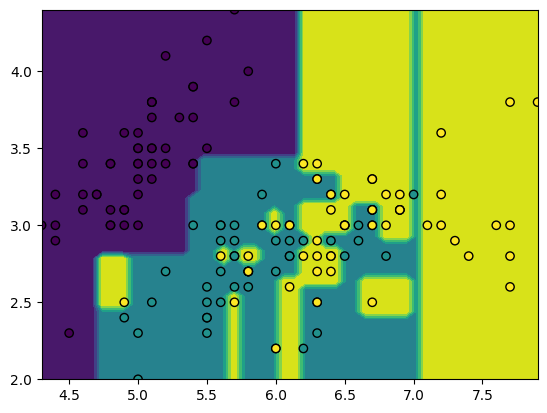

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
feature_1, feature_2 = np.meshgrid(
    np.linspace(iris.data[:, 0].min(), iris.data[:, 0].max()),
    np.linspace(iris.data[:, 1].min(), iris.data[:, 1].max()),
)
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
tree = DecisionTreeClassifier().fit(iris.data[:, :2], iris.target)
y_pred = np.reshape(tree.predict(grid), feature_1.shape)
display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)
display.plot()
display.ax_.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target, edgecolor="black")
plt.show()

In [32]:
exp.save(overwrite_existing=True)

Loading 'classification-experiments.csv'
Overwriting existing experiment dtc-iris-postpruned
Saving experiment dtc-iris-postpruned to results/classification-experiments.csv
Dumping estimator dtc-iris-postpruned to .cache/dtc-iris-postpruned.joblib


## Conclusions

TODO - SO PRUNING GIVES THE SAME AS UNPRUNED BECAUSE GRIDSEARCH OPTIMIZED FOR ACCURACY.

I found that gridsearch for the best ccpalpha hyperparamer in my postpruning experiement selects 0 for ccpalpha (no pruning) I guess because that optimizes the accuracy...isn't that problematic?